# Credit Card Fraud Detection
#### By Shadi Bavar, Matthew Euliano, and Claire Parisi


##### Importing Required Libraries & Dataset

In [1]:
#Importing the libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.svm import SVC

In [2]:
# Import Data
data = pd.read_csv('creditcard.csv')

# Get samples for each class
fraudsDF = data[data.Class == 1]
normalDF = data[data.Class == 0]
N = len(data)

print("Number of Features: ", fraudsDF.shape[1])
print("Number of Fraudulent Transactions: ",fraudsDF.shape[0], "({:.2f}%)".format(100*fraudsDF.shape[0]/N))
print("Number of Normal Transactions",normalDF.shape[0], "({:.2f}%)".format(100*normalDF.shape[0]/N))

#See the dataset
data.head()

Number of Features:  31
Number of Fraudulent Transactions:  492 (0.17%)
Number of Normal Transactions 284315 (99.83%)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


##### Visualization

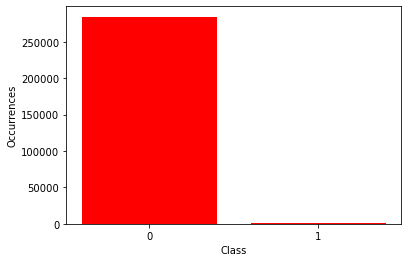

In [3]:
#Plot number of each class: data is skewed
plt.hist(data['Class'], bins = [-.4, .4, .6, 1.4], color = 'red')
plt.xlabel('Class')
plt.xticks([0, 1])
plt.ylabel('Occurrences')
plt.show()

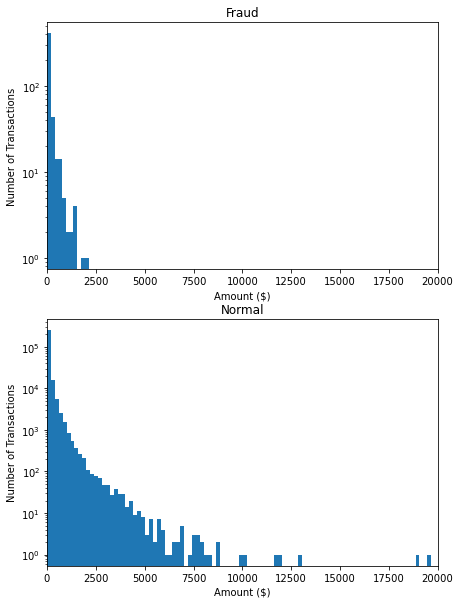

In [4]:
# Plot amount per transaction for Fraud and Normal Transactions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (7, 10))
ax1.hist(fraudsDF.Amount, bins = round(max(fraudsDF.Amount)/200))
ax1.set_title('Fraud')
ax1.set_xlabel('Amount ($)')
ax1.set_ylabel('Number of Transactions')
ax1.set_xlim ((0, 20000))
ax1.set_yscale('log')
ax2.hist(normalDF.Amount, bins = round(max(normalDF.Amount)/200))
ax2.set_title('Normal')
ax2.set_xlabel('Amount ($)')
ax2.set_ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

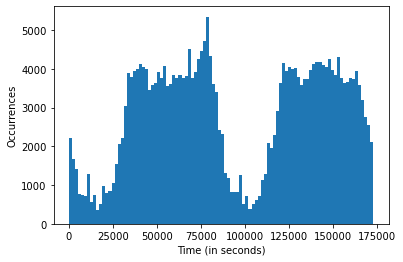

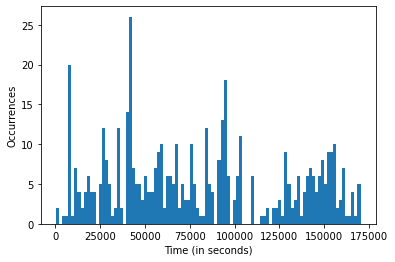

In [5]:
# Time Trends
#Distribution of transaction times
plt.hist(data['Time'], bins = 100)
plt.xlabel('Time (in seconds)')
plt.ylabel('Occurrences')
plt.show()

#Distribution of fraudulent transaction times
plt.hist(fraudsDF['Time'], bins = 100)
plt.xlabel('Time (in seconds)')
plt.ylabel('Occurrences')
plt.show()

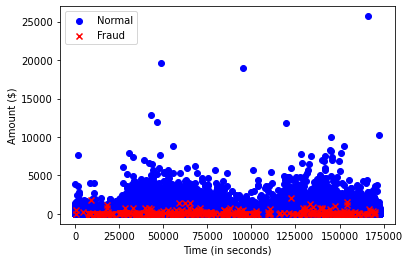

In [6]:
#Time vs Amount Feature Plot
plt.scatter(normalDF['Time'], normalDF['Amount'], color = 'blue', label = 'Normal')
plt.scatter(fraudsDF['Time'],  fraudsDF['Amount'], color = 'red', marker = 'x', label = 'Fraud')
plt.xlabel('Time (in seconds)')
plt.ylabel('Amount ($)')
plt.legend()
plt.show()

#### Regularize Features & Data Prep

In [7]:
#Scaling amount 
std_scale = StandardScaler()
data['Amount'] = std_scale.fit_transform(data['Amount'].values.reshape(-1, 1))

#Split dataset into inputs (x) and labels (y)
x = data.drop(['Class'], axis = 1)
y = data['Class']

#### Break dataset into Training and Testing Sets Representative of the Imbalanced Dataset

In [8]:
#split dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y)

#check distributions of data
fraud_train_pct = y_train[y_train== 1].value_counts()/len(y_train)*100
fraud_test_pct = y_test[y_test == 1].value_counts()/len(y_test)*100

print('Training set frauds:', round(fraud_train_pct[1], 2), '%')
print('Test set frauds:', round(fraud_test_pct[1], 2), '%')


Training set frauds: 0.17 %
Test set frauds: 0.17 %


#### Undersample the Training Set to Balance the Classes

In [9]:

#find instances of fraud in training set
train_fraud_indices = np.array(y_train[y_train== 1].index)
n_train_fraud = len(train_fraud_indices)
train_nonfraud_indices = np.array(y_train[y_train== 0].index)

#Randomly select number of non-fraud transactions to match the number of fraud transactions
random_indices = np.random.choice(train_nonfraud_indices, n_train_fraud, replace = False)
undersample_indices = np.concatenate([train_fraud_indices, random_indices])

#Resample the training data
x_train_u  = x_train.loc[undersample_indices]
y_train_u = y_train.loc[undersample_indices]

#Check the new distribution of data
fraud_train_pct_u = y_train_u[y_train_u== 1].value_counts()/len(y_train_u)*100
nonfraud_train_pct_u = y_train_u[y_train_u== 0].value_counts()/len(y_train_u)*100
print('Training set frauds:', round(fraud_train_pct_u[1], 2), '%')
print('Training set non-frauds:', round(nonfraud_train_pct_u[0], 2), '%')

Training set frauds: 50.0 %
Training set non-frauds: 50.0 %


#### SVM

In [33]:
# Functions to test and train different SVM Models
from sklearn.metrics import classification_report
def train_svm_model(x,y,C,kernel,class_weight):
    model = SVC(C=C,kernel=kernel,class_weight=class_weight)
    model.fit(x, y)
    return model
    
def test_svm_model(x,y,model):
    prediction = model.predict(x)
    print(confusion_matrix(y,prediction))
    # ConfusionMatrixDisplay.from_predictions(y,prediction)
    # report= classification_report(y, prediction)
    # print(report)

In [34]:
# Balanced Model
svm_base = train_svm_model(x_train_u,y_train_u,1,'linear','balanced')
print("Base SVM Confusion Matrix tested on Training Set")
test_svm_model(x_train_u,y_train_u,svm_base)
print("Base SVM Confusion Matrix tested on Test Set")
test_svm_model(x_test,y_test,svm_base)

Base SVM Confusion Matrix tested on Training Set
[[391   3]
 [ 79 315]]
Base SVM Confusion Matrix tested on Test Set
[[56402   462]
 [   26    72]]


In [35]:
# put more weight on the Fraud Class
# {class0:weight0, class1:weight1}
class_weight = {0:1, 1:2.5}
svm_weighted = train_svm_model(x_train_u,y_train_u,1,'linear',class_weight)
print("Weighted SVM Confusion Matrix tested on Training Set")
test_svm_model(x_train_u,y_train_u,svm_weighted)
print("Weighted SVM Confusion Matrix tested on Test Set")
test_svm_model(x_test,y_test,svm_weighted)

Weighted SVM Confusion Matrix tested on Training Set
[[380  14]
 [ 25 369]]
Weighted SVM Confusion Matrix tested on Test Set
[[54284  2580]
 [   11    87]]


#### TODO - Cross-Validation: Hyperparams we can vary = Kernel, C-param, Class Weighting